### Deep Learning Project 
##### Authors : Marvin Tordjman - Sajjad Mahdavi - Yanis Fellah 

#### $\bullet$ Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import random

from scipy.special import softmax
#For read .mat file 
import scipy.io


#### $\bullet$ Construction d’un RBM et test sur Binary AlphaDigits

In [2]:
def lire_alpha_digit(character, data):
    """
    function that takes a character list and 
    returns the data in matrix form
    """
    n, n_car, height, width = 39, 36, 20, 16
    list_caracter = np.array(list(map(chr, range(48, 58))) + list(map(chr, range(97, 123))))
    index_car = [int(np.where(list_caracter == character[i])[0]) for i in range(len(character))]
    X = np.concatenate(np.concatenate(data['dat'][index_car], axis = 0), axis = 0).reshape(len(character)*n, height*width)
    print(f'the shape of the data is = {X.shape}')
    return X
    

In [3]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [4]:
class RBM():
    """
    a class representing a Restricted Boltzmann Machine (RBM)
    """
    def __init__(self, nv, nh):
        self.a = np.zeros(nv)
        self.b = np.zeros(nh)
        self.W = np.sqrt(0.01)*np.random.randn(nv, nh)

In [5]:
def init_RBM(nv, nh):
    """
    function that takes the number of visible (nv) and hidden (nh) units and 
    returns a Restricted Boltzmann machine (RBM) initialized with 
    bias 0 and the weights (W) will be randomly initialized according to a centered normal distribution. 
    """
    rbm = RBM(nv, nh)
    return rbm

def entree_sortie_RBM(X, rbm):
    """
    function that takes an MBR and input data and 
    returns the value of the output units calculated from the sigmoid function.
    """
    return sigmoid(X@rbm.W + rbm.b)


def sortie_entree_RBM(H, rbm):
    """
    function that takes an MBR and output data and 
    returns the value of the input units from the sigmoid function.
    """
    return sigmoid(H@rbm.W.T + rbm.a)


In [6]:
# Contrastive Divergence Algorithm = Training
def train_RBM(X, rbm, num_epoch = 100, lr = 1e-1, batch_size = 5, plot=False, verbose=False):
    """
    function that allows to learn RBM parameters using Contrastive Divergence Algorithm. 
    The function takes the input data, an initialized RBM, the number of epochs, learning rate, batch-size 
    returns a trained RBM.
    If 'plot = True' the function displays the squared error between the input data and the reconstructed data 
    If 'verboe = True' we print the squared error at each epoch
    """

    n = X.shape[0]
    nv, nh = rbm.W.shape
    partial_loss = []
    for epoch in range(num_epoch):
        X_copy = np.copy(X)
        np.random.shuffle(X_copy)
        for batch in range(0, n, batch_size):
            X_batch = np.copy(X_copy)[batch:min(batch+batch_size, n)]
            tb = X_batch.shape[0]
            v_0 = np.copy(X_batch)
            p_h_given_v_0 = entree_sortie_RBM(v_0, rbm)
            h_0 = (np.random.rand(tb, nh) < p_h_given_v_0)*1
            p_v_given_h_0 = sortie_entree_RBM(h_0, rbm)
            v_1 = (np.random.rand(tb, nv) < p_v_given_h_0)*1
            p_h_given_v_1 = entree_sortie_RBM(v_1, rbm)
            
            #Gradient of parameters
            grad_a = np.sum(v_0 - v_1, axis = 0)
            grad_b = np.sum(p_h_given_v_0 - p_h_given_v_1, axis = 0)
            grad_W = v_0.T@p_h_given_v_0 - v_1.T@p_h_given_v_1
            
            #Update weights and bias
            rbm.W += (lr/tb)*grad_W
            rbm.a += (lr/tb)*grad_a
            rbm.b += (lr/tb)*grad_b

        if(verbose):
            H = entree_sortie_RBM(X, rbm)
            X_rec = sortie_entree_RBM(H, rbm)
            partial_loss.append( np.mean((X-X_rec)**2))
            print("Epoch : %1i/%1i, Error = %.3f" %(epoch,num_epoch,partial_loss[-1]))
        
    if plot:
        plt.scatter(x = np.arange(1,num_epoch+1,1), y = partial_loss)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Error')
        plt.title('Error between Real Data and Reconstructed Data')
            
    return rbm

In [7]:
# Generating data with RBM architecture
def generer_image_RBM(rbm, num_iter_gibs, num_gen, height, width):
    """
    Function to generate binary images.
    This function takes a trained RBM, the number of generated images and the number of iteration gibbs 
    returns of the generated images.
    """
    
    fig = plt.figure(figsize=(20,5))
    num_rows = int(num_gen/10)+1
    nv, nh = rbm.W.shape
    X_con = np.zeros((num_gen, nv))
    for i in range(num_gen):
        v = (np.random.rand(nv) < 1/2)*1
        for iter_gibs in range(num_iter_gibs):
            h = (np.random.rand(nh) < entree_sortie_RBM(v, rbm))*1
            v = (np.random.rand(nv) < sortie_entree_RBM(h, rbm))*1
        X_con[i] = v
        ax = fig.add_subplot(num_rows, 10, i+1)
        plt.imshow(X_con[i].reshape(height, width), cmap='gray')
    return X_con

In [8]:
def principal_RBM_alpha(X, height, width, nh, num_gen, num_epoch=100, lr=1e-1, batch_size=8, num_iter_gibs=5, verbose=False, plot=True):
    """
    A function that gradually learns characters from 
    the Binary AlphaDigits database of your choice via an RBM and generates characters similar to those learned.
    """
    #data = scipy.io.loadmat('binaryalphadigs.mat')
    #n, n_car, height, width = 39, 36, 20, 16

    #X = lire_alpha_digit(character, data)

    #Initilization
    rbm = init_RBM(height*width, nh)
    #Training
    rbm = train_RBM(X, rbm, num_epoch, lr, batch_size, plot=plot, verbose=verbose)
    #Generation
    X_generated = generer_image_RBM(rbm, num_iter_gibs, num_gen, height, width)

    return rbm
    

#### $\bullet$ Construction d’un DBN et test sur Binary AlphaDigits

In [9]:
def init_DBN(nv, nh, num_layer):
    """
    this function allows to build and initialize randomly the weights and biases of a Deep Boltzmann Network DBN.
    This function will return a DBN, 
    taking as argument the number of visible and hidden units and also the number of layers in the network.
    """
    dbn = []
    dbn.append(init_RBM(nv, nh))
    for i in range(1, num_layer):
        dbn.append(init_RBM(nh, nh))
    return dbn


def train_DBN(X, dbn, num_epoch = 100, lr = 1e-1, batch_size = 8):
    """
    This function will return a pre-trained DBN and 
    will take as argument a DBN, the number of epochs, the learning rate, the batch-size, input data
    """
    num_layer = len(dbn)
    #X at layer l
    X_l = np.copy(X)
    for i in range(num_layer):
        dbn[i] = train_RBM(X_l, dbn[i], num_epoch, lr, batch_size)
        p_v_given_h = entree_sortie_RBM(X_l, dbn[i])
        X_l = (np.random.rand(X_l.shape[0], p_v_given_h.shape[1]) < p_v_given_h)*1
    return dbn


In [35]:
# Generating data with DBN architecture
def generer_image_DBN(dbn, num_iter_gibs, num_gen, height, width):
    """
    Function to generate binary images.
    This function takes a trained DBN, the number of generated images and the number of iteration gibbs 
    returns the generated images.
    """
    fig = plt.figure(figsize=(20,5))
    num_rows = int(num_gen/10)+1
    nv = dbn[0].W.shape[0]
    num_layers = len(dbn)
    X_con = np.zeros((num_gen, nv))
    for i in range(num_gen):
        v = (np.random.rand(nv) < 1/2)*1
        for iter_gibs in range(num_iter_gibs):
            for l in range(num_layers): 
                nv, nh = dbn[l].W.shape
                v = (np.random.rand(nh) < entree_sortie_RBM(v, dbn[l]))*1
            for l in range(num_layers-1, -1, -1):
                nv, nh = dbn[l].W.shape
                v = (np.random.rand(nv) < sortie_entree_RBM(v, dbn[l]))*1
        X_con[i] = v
        ax = fig.add_subplot(num_rows, 10, i+1)
        plt.imshow(X_con[i].reshape(height,width), cmap='gray')
    return X_con

In [11]:
def principal_DBN_alpha(X, height, width, nh, num_layers, num_gen, num_epoch=100, lr=1e-1, batch_size=8, num_iter_gibs=5, verbose=False, plot=True):
    """
    A function that gradually learns characters from 
    the Binary AlphaDigits database of your choice via an DBN and generates characters similar to those learned.
    """

    #Initilization
    dbn = init_DBN(height*width, nh, num_layers)
    #Training
    dbn = train_DBN(X, dbn, num_epoch, lr, batch_size)
    #Generation
    X_generated = generer_image_DBN(dbn, num_iter_gibs, num_gen, height, width)

    return dbn

#### $\bullet$ Construction d’un DNN et test sur MNIST

In [12]:
def init_DNN(nv, nh, num_layer):
    """
    A function that takes the number of visible (nv) and hidden (nh) units and the number of layers
    returns an initialized Deep Belif Network DNN
    """
    dnn = init_DBN(nv, nh, num_layer)
    dnn.append(init_RBM(nh, 10))
    return dnn


def pretrain_DNN(X, dnn, num_epoch = 100, lr = 1e-1, batch_size = 64):
    """
    This function will return a pre-trained DNN (except the classification layer) and 
    will take as arguments a DNN, the number of epochs, the learning rate, the batch-size, and the input data.
    """
    l = len(dnn)
    dnn[:(l-1)] = train_DBN(X, dnn[:(l-1)], num_epoch = num_epoch, lr = lr, batch_size = batch_size)
    return dnn

def calcul_softmax(X, rbm):
    """
    Applies the Softmax function to the output of the classification layer.
    """
    return softmax(X@rbm.W + rbm.b , axis=1)


def entree_sortie_reseau(X, dnn):
    """
    function that takes as argument a DNN, data in input of the network and 
    returns in a list the outputs on each layer of the network (input layer included) 
    as well as the probabilities on the output units. (after the application of softmax)
    """
    l = len(dnn) #Number of the layers
    X_list = [] #List of output after each layer
    X_list.append(X)
    for i in range(l-1):
        X_list.append(entree_sortie_RBM(X_list[-1], dnn[i]))
    X_list.append(calcul_softmax(X_list[-1], dnn[-1]))
    return X_list


Some Elementary Functions

In [13]:
def CrossEntropyLoss(y, y_pred):
    """
    This criterion computes the cross entropy loss between input logits and target.
    """
    return -np.mean(np.log(y_pred)*y)


def to_one_hot(y):
    """
    Encode categorical features as a one-hot numeric array.
    """
    ohe = np.zeros((y.size, 10))
    ohe[np.arange(y.size),y] = 1
    return ohe

def accuracy(output, labels):
    """
    function that calculates the error rate
    """
    correct = np.sum(np.argmax(output, axis=1) == np.argmax(labels, axis=1))
    return correct / len(labels)


In [14]:
def retropropagation(X, y, dnn, num_epoch = 100, lr = 1e-1, batch_size = 64, verbose = True):
    """
    This function will return a DNN and 
    will take as argument a DNN, the number of epochs, the learning rate, 
    the batch-size, some input data, their label.
    """
    n = X.shape[0]
    l = len(dnn)    
    for epoch in range(num_epoch):
        loss = 0
        X_copy, y_copy = np.copy(X), np.copy(y)
        shuffle = np.random.permutation(n)
        X_copy, y_copy = X_copy[shuffle], y_copy[shuffle]
        for batch in range(0, n, batch_size):
            X_batch = np.copy(X_copy)[batch:min(batch+batch_size, n)]
            y_batch = np.copy(y_copy)[batch:min(batch+batch_size, n)]
            y_batch_ohe = to_one_hot(y_batch)

            tb = X_batch.shape[0]

            pred = entree_sortie_reseau(X_batch, dnn)
            loss += CrossEntropyLoss(y_batch_ohe, pred[-1])

            for i in range(l):
                if i==0:
                    delta = pred[l] - y_batch_ohe
                else :
                    delta = grad_a*(pred[l-i]*(1-pred[l-i]))

                #Gradient of parameters
                grad_W = 1/tb * pred[l-i-1].T.dot(delta)
                grad_b = 1/tb * np.sum(delta, axis=0)
                grad_a = delta.dot(dnn[l-i-1].W.T)

                #Update weights and bias
                dnn[l-i-1].W -=  lr*grad_W
                dnn[l-i-1].b -= lr*grad_b
        if verbose:
            print(f"Epoch {epoch}/{num_epoch} the loss is = {loss/batch_size}")
    return dnn
            

In [15]:
def test_DNN(dnn, X, y, verbose=False):
    """
    This function takes as argument a learned DNN, a test data set, and the associated real labels
    """
    y_ohe = to_one_hot(y)
    pred = entree_sortie_reseau(X, dnn)
    error = 1 - accuracy(pred[-1], y_ohe)
    if verbose :
        print(f"The Accuracy of the model is {error}")
    return error


#### $\bullet$ Etude sur Binary AlphaDigit

In [16]:
num_epochs = 100
lr = 1e-1
batch_size = 8
num_layers = 3
nh = 100
num_iter_gibs = 5
num_gen = 5

In [17]:
data = scipy.io.loadmat('Data/AlphaDigits/binaryalphadigs.mat')
n, n_car, height, width = 39, 36, 20, 16

X = lire_alpha_digit(['a'], data)

the shape of the data is = (39, 320)


##### Training of RBM

##### An overview of the regenerated images for RBM, depending on the number of neurons

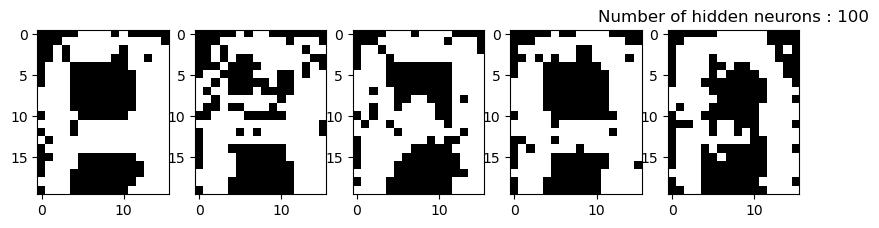

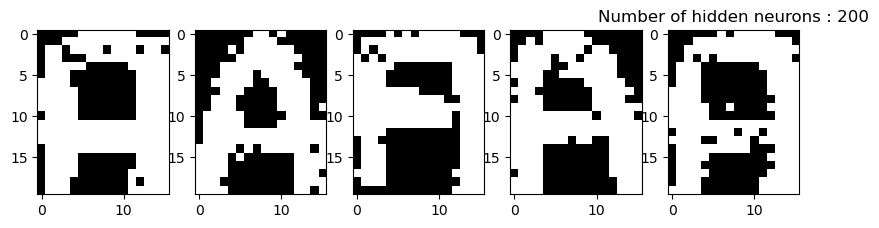

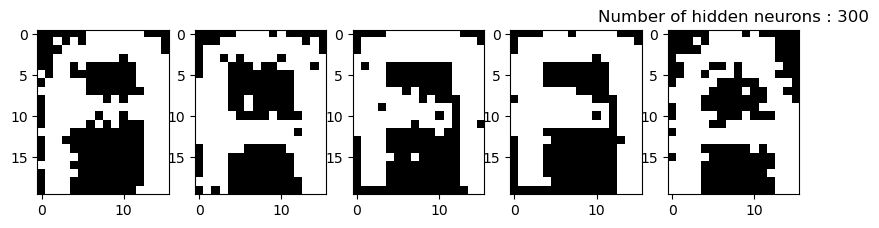

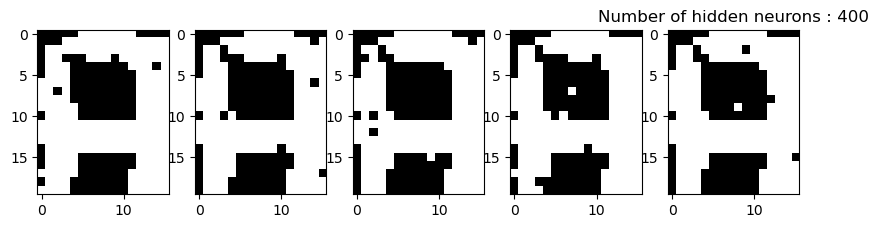

In [31]:
nhs = [100, 200 ,300, 400]
for nh in nhs:
    principal_RBM_alpha(X, height, width, nh, num_gen=num_gen, num_epoch=num_epochs, lr=lr,
                    batch_size=batch_size, num_iter_gibs=num_iter_gibs, verbose=False, plot=False)
    plt.title(f"Number of hidden neurons : {nh}")
    #plt.savefig("AlphaD1"+str(nh)+".pdf", format="pdf", bbox_inches="tight")

##### An overview of the regenerated images for RBM, depending on the number of characters

the shape of the data is = (39, 320)
the shape of the data is = (78, 320)
the shape of the data is = (117, 320)
the shape of the data is = (156, 320)


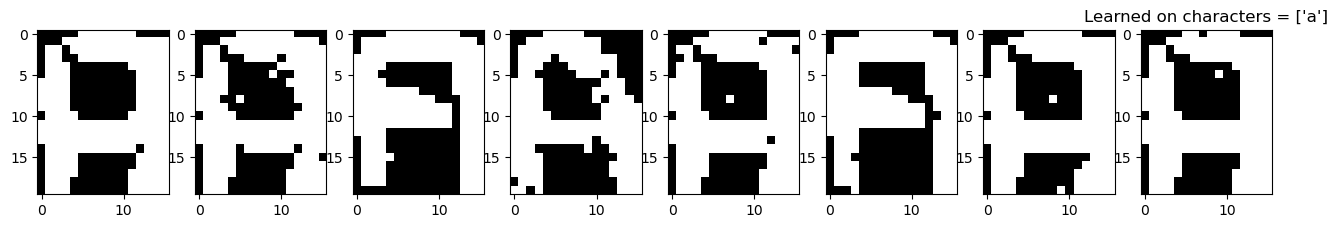

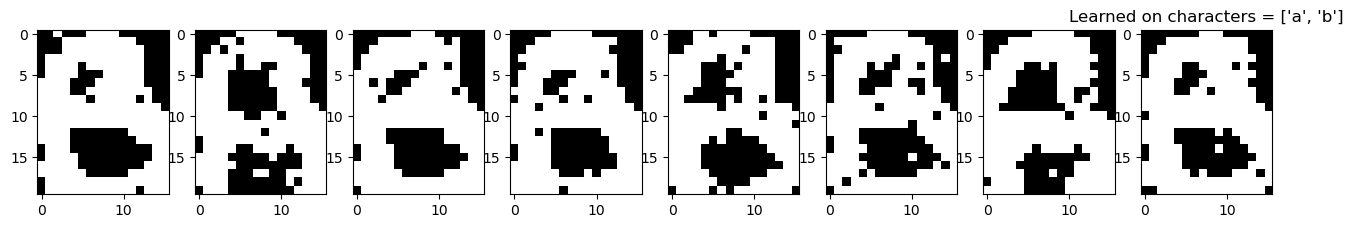

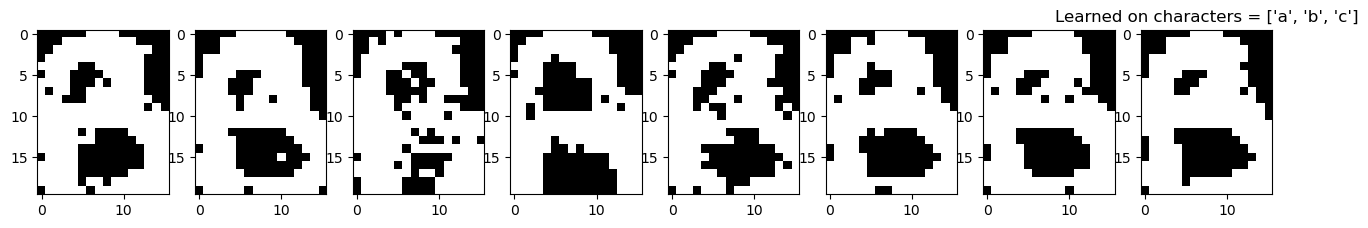

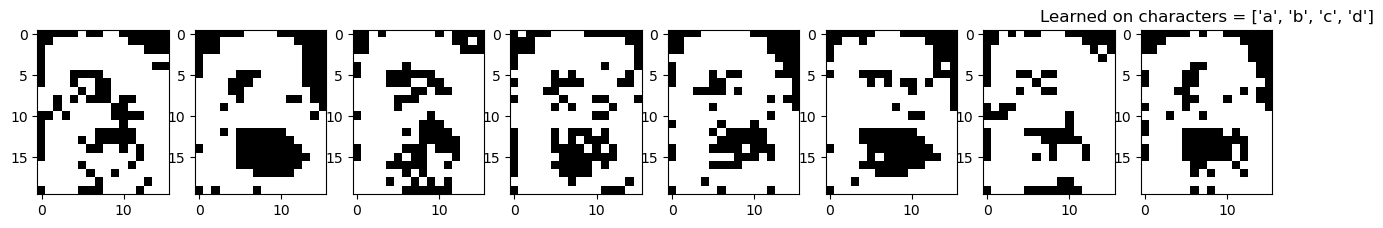

In [30]:
characters = [['a'], ['a','b'], ['a', 'b', 'c'], ['a', 'b', 'c', 'd']]
for char in characters:
    X_test = lire_alpha_digit(char, data)
    principal_RBM_alpha(X_test, height, width, nh, num_gen=8, num_epoch=num_epochs, lr=lr,
                    batch_size=batch_size, num_iter_gibs=num_iter_gibs, verbose=False, plot=False)
    plt.title(f"Learned on characters = {char}")
    #plt.savefig("AlphaD2"+str(len(char))+".pdf", format="pdf", bbox_inches="tight")
    

##### Training of DBN

##### An overview of the regenerated images for DBN, depending on the number of neurons

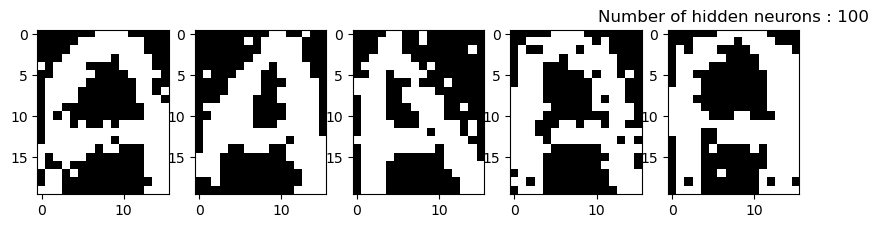

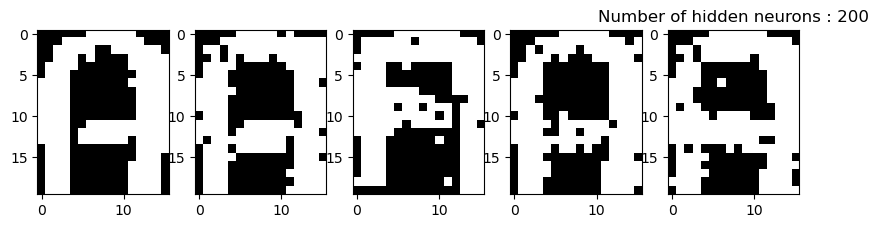

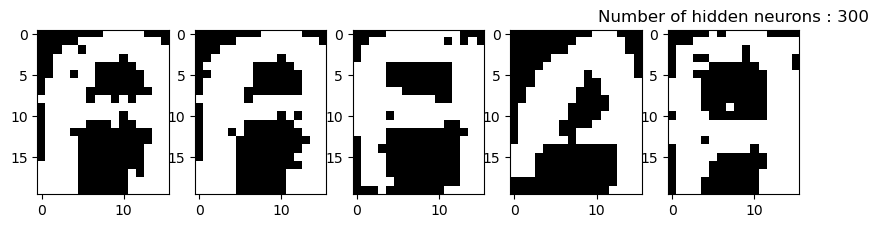

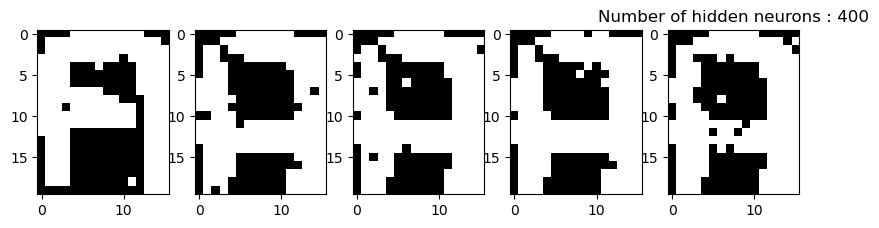

In [37]:
nhs = [100, 200 ,300, 400]
for nh in nhs:
    principal_DBN_alpha(X, height, width, nh, num_layers, num_gen=num_gen, num_epoch=num_epochs, lr=lr,
                    batch_size=batch_size, num_iter_gibs=num_iter_gibs, verbose=False, plot=False)
    plt.title(f"Number of hidden neurons : {nh}")
    plt.savefig("AlphaDBN"+str(nh)+".pdf", format="pdf", bbox_inches="tight")

##### An overview of the regenerated images for DBN, depending on the number of layers

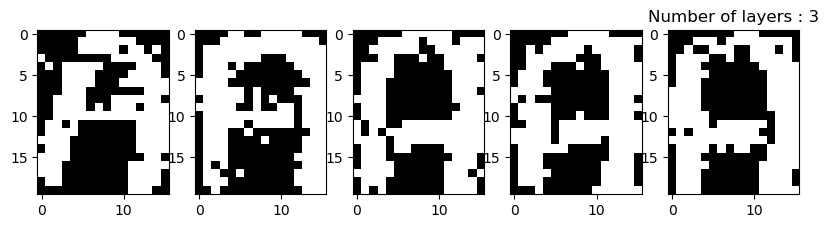

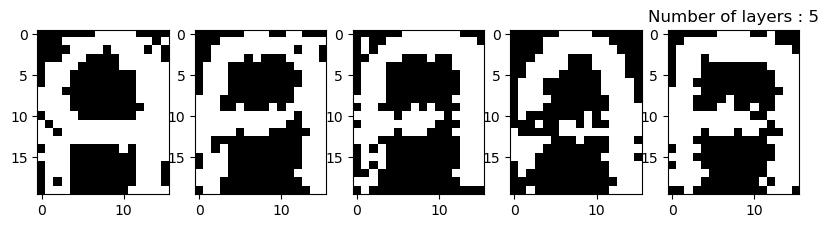

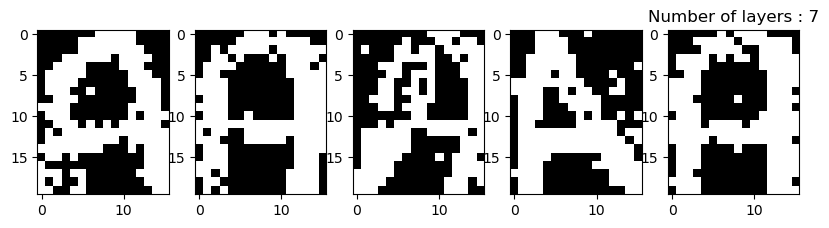

In [39]:
nh = 100 
nls = [3 ,5 ,7]
for nl in nls:
    principal_DBN_alpha(X, height, width, nh, nl, num_gen=num_gen, num_epoch=num_epochs, lr=lr,
                    batch_size=batch_size, num_iter_gibs=num_iter_gibs, verbose=False, plot=False)
    plt.title(f"Number of layers : {nl}")
    plt.savefig("layers"+str(nl)+".pdf", format="pdf", bbox_inches="tight")

##### An overview of the regenerated images for DBN, depending on the number of characters


the shape of the data is = (39, 320)
the shape of the data is = (78, 320)
the shape of the data is = (117, 320)
the shape of the data is = (156, 320)


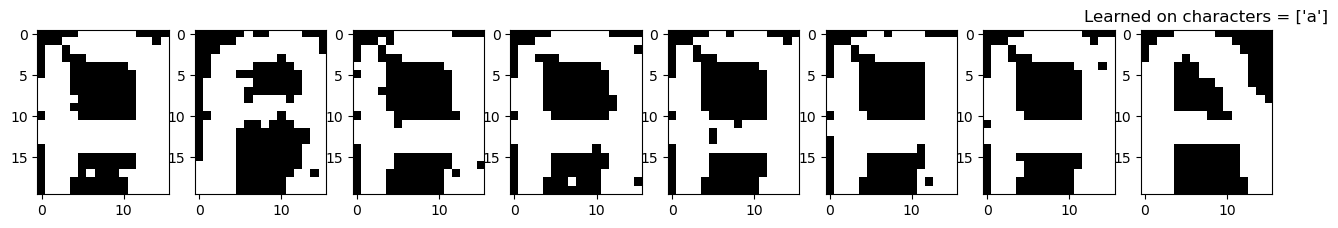

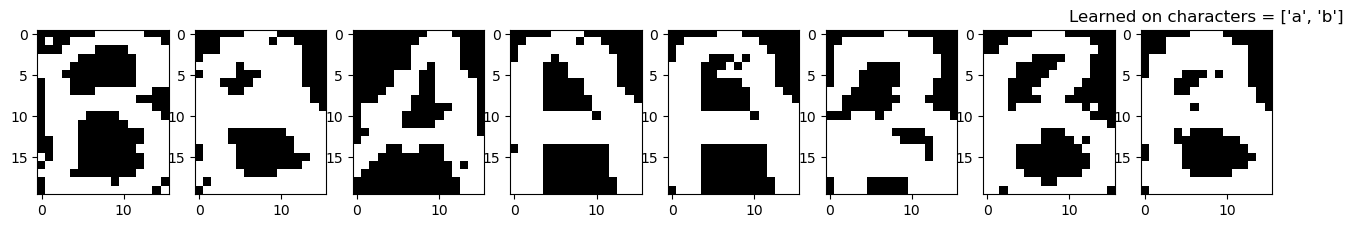

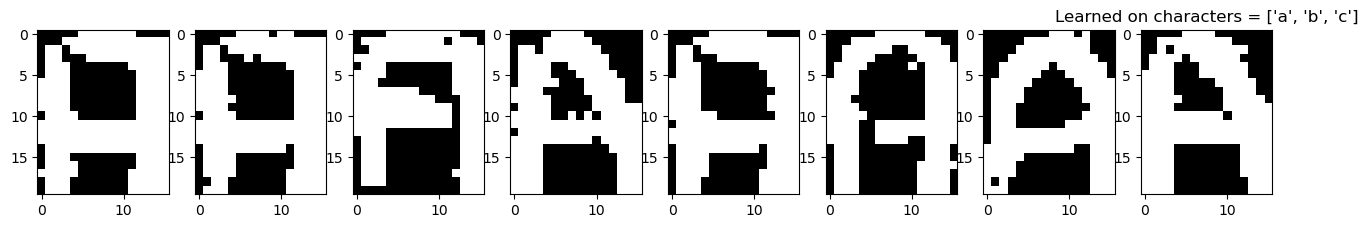

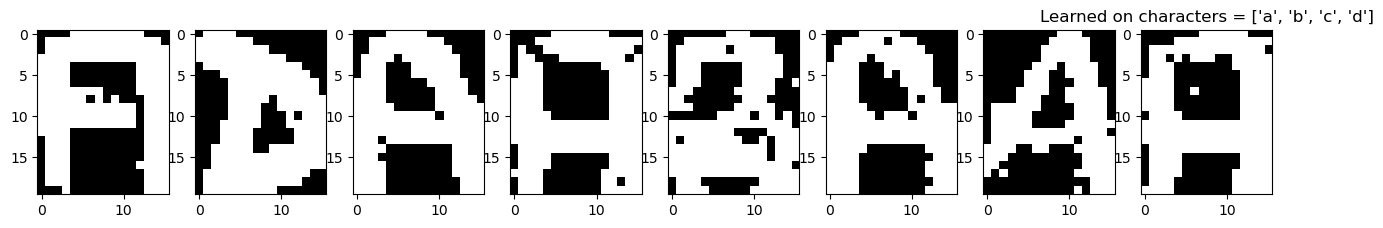

In [44]:
characters = [['a'], ['a','b'], ['a', 'b', 'c'], ['a', 'b', 'c', 'd']]
for char in characters:
    X_test = lire_alpha_digit(char, data)
    principal_DBN_alpha(X_test, height, width, 500, num_layers, num_gen=8, num_epoch=num_epochs, lr=lr,
                    batch_size=batch_size, num_iter_gibs=num_iter_gibs, verbose=False, plot=False)
    plt.title(f"Learned on characters = {char}")
    plt.savefig("char"+str(len(char))+".pdf", format="pdf", bbox_inches="tight")

#### $\bullet$ Étude à réaliser sur MNIST

##### Programme

Specify the parameters related to the network and learning.

In [20]:
num_layers = 3
num_epochs_rbm = 50
num_epochs_retro = 50
lr = 1e-1
batch_size = 64
n_samples = 30000
height, width = 28, 28
nh = 200


Loading the Data

In [21]:
#pip install python-mnist

In [21]:
def binarize_mnist(X):
    X_b = np.zeros(X.shape)
    X_b[X >= 128] = 1
    return X_b

In [22]:
from mnist import MNIST

mndata = MNIST('../Deep Learning II/MNIST')

X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

X_train = binarize_mnist(np.array(X_train)).astype(np.int32)
y_train = np.array(y_train).astype(np.int32)
X_test = binarize_mnist(np.array(X_test)).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)

In [23]:
def principal_DNN_MNIST(X_train, y_train, n_samples, dnn, pre_train, num_epochs_rbm = 100, num_epochs_retro = 200, lr = 1e-1, batch_size = 64, verbose = False):
    """
    A function that progressively learns a pre-trained deep neural network via a DBN.
    """
    
    mask = random.sample(list(np.arange(X_train.shape[0])), n_samples)
    X_train = X_train[mask]
    y_train = y_train[mask]

    if pre_train:
        dnn = pretrain_DNN(X_train, dnn, num_epochs_rbm, lr, batch_size)
    dnn = retropropagation(X_train, y_train, dnn, num_epochs_retro, lr, batch_size)
    return dnn

##### Analyse

In [95]:
layers_list = [2, 3, 5]
error_train_1 = []
error_train_2 = []
error_test_1 = []
error_test_2 = []

for l in layers_list:
    print(f"Training of network with {l} layers")
    dnn_random = init_DNN(height*width, nh, l)
    dnn_pre_trained = init_DNN(height*width, nh, l)

    dnn_random = principal_DNN_MNIST(n_samples, dnn_random, False, num_epochs_rbm, num_epochs_retro, lr, batch_size)
    dnn_pre_trained = principal_DNN_MNIST(n_samples, dnn_pre_trained, True, num_epochs_rbm, num_epochs_retro, lr, batch_size)
    

    ###### Misclassification rates #######
    print('Calculating errors on the train and test set')
    #Train 
    error_train_1.append(test_DNN(dnn_random, X_train, y_train))
    error_train_2.append(test_DNN(dnn_pre_trained, X_train, y_train))
    #Test
    error_test_1.append(test_DNN(dnn_random, X_test, y_test))
    error_test_2.append(test_DNN(dnn_pre_trained, X_test, y_test))



Training of network with 2 layers
Epoch 0/50 the loss is = 1.4877703369186728
Epoch 1/50 the loss is = 0.5918420405089625
Epoch 2/50 the loss is = 0.4943650019139977
Epoch 3/50 the loss is = 0.4453065414775144
Epoch 4/50 the loss is = 0.4092660853107588
Epoch 5/50 the loss is = 0.3776546428688136
Epoch 6/50 the loss is = 0.3502359827204798
Epoch 7/50 the loss is = 0.3263926879151648
Epoch 8/50 the loss is = 0.30420378207636256
Epoch 9/50 the loss is = 0.2834832181142687
Epoch 10/50 the loss is = 0.2647541480016054
Epoch 11/50 the loss is = 0.2482804297334287
Epoch 12/50 the loss is = 0.2328350802107645
Epoch 13/50 the loss is = 0.21927266860588907
Epoch 14/50 the loss is = 0.2064271584474594
Epoch 15/50 the loss is = 0.19558441954784875
Epoch 16/50 the loss is = 0.18469565896770737
Epoch 17/50 the loss is = 0.17495466282833724
Epoch 18/50 the loss is = 0.16576496855245462
Epoch 19/50 the loss is = 0.15734160590801027
Epoch 20/50 the loss is = 0.14962512805159944
Epoch 21/50 the loss is

#### Figure 1 : Error rate of train and test sets according to number of layers

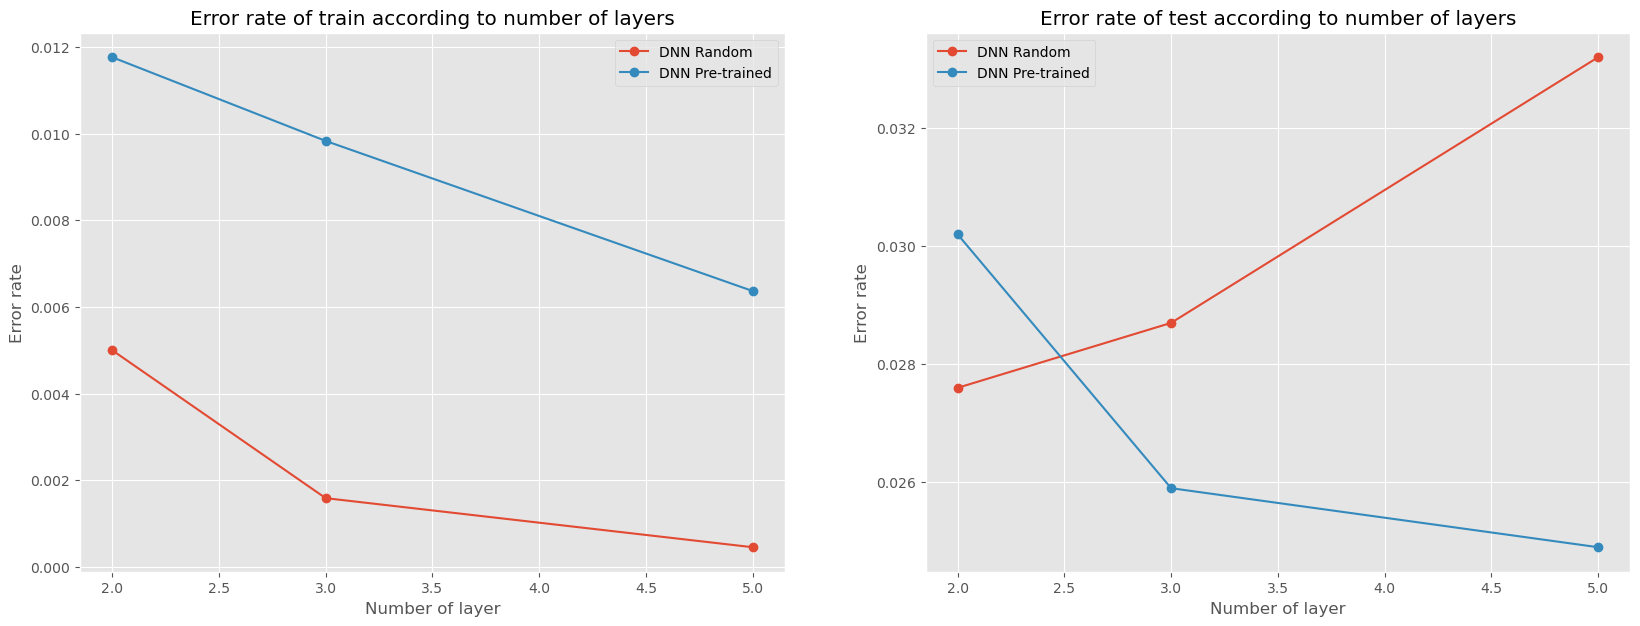

In [107]:
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(1, 2, 2)
plt.plot(layers_list, error_test_1, label='DNN Random', marker='o')
plt.plot(layers_list, error_test_2, label='DNN Pre-trained', marker='o')
plt.xlabel("Number of layer")
plt.ylabel("Error rate")
plt.title("Error rate of test according to number of layers")
plt.legend()

ax = fig.add_subplot(1, 2, 1)
plt.plot(layers_list, error_train_1, label='DNN Random', marker='o')
plt.plot(layers_list, error_train_2, label='DNN Pre-trained', marker='o')
plt.xlabel("Number of layer")
plt.ylabel("Error rate")
plt.title("Error rate of train according to number of layers")
plt.legend()

plt.savefig("Fig1.pdf", format="pdf", bbox_inches="tight")


In [35]:
num_layers = 2
nhs = [100, 300, 700]
error_train_1 = []
error_train_2 = []
error_test_1 = []
error_test_2 = []

for nh in nhs:
    print(f"Training of network with {nh} hidden neurons ")
    dnn_random = init_DNN(height*width, nh, num_layers)
    dnn_pre_trained = init_DNN(height*width, nh, num_layers)

    dnn_random = principal_DNN_MNIST(X_train, y_train, n_samples, dnn_random, False, num_epochs_rbm, num_epochs_retro, lr, batch_size)
    dnn_pre_trained = principal_DNN_MNIST(X_train, y_train, n_samples, dnn_pre_trained, True, num_epochs_rbm, num_epochs_retro, lr, batch_size)
    

    ###### Misclassification rates #######
    print('Calculating errors on the train and test set')
    #Train 
    error_train_1.append(test_DNN(dnn_random, X_train, y_train))
    error_train_2.append(test_DNN(dnn_pre_trained, X_train, y_train))
    #Test
    error_test_1.append(test_DNN(dnn_random, X_test, y_test))
    error_test_2.append(test_DNN(dnn_pre_trained, X_test, y_test))


Training of network with 100 hidden neurons 
Epoch 0/50 the loss is = 1.3690594236875993
Epoch 1/50 the loss is = 0.5784393388211768
Epoch 2/50 the loss is = 0.3729965385189343
Epoch 3/50 the loss is = 0.30432734770481384
Epoch 4/50 the loss is = 0.26852536728526777
Epoch 5/50 the loss is = 0.24622978970642484
Epoch 6/50 the loss is = 0.2295756439456687
Epoch 7/50 the loss is = 0.2165291456525573
Epoch 8/50 the loss is = 0.20488954450083507
Epoch 9/50 the loss is = 0.1945168621833992
Epoch 10/50 the loss is = 0.18527215165488498
Epoch 11/50 the loss is = 0.17650144283216465
Epoch 12/50 the loss is = 0.168501515286199
Epoch 13/50 the loss is = 0.16117596543073265
Epoch 14/50 the loss is = 0.1542196919501669
Epoch 15/50 the loss is = 0.14799974274336541
Epoch 16/50 the loss is = 0.14179605165278622
Epoch 17/50 the loss is = 0.13618911895748215
Epoch 18/50 the loss is = 0.13059743455946307
Epoch 19/50 the loss is = 0.125460413436457
Epoch 20/50 the loss is = 0.12114023131445224
Epoch 21/5

#### Figure 2 : Error rate of train and test sets according to number of hidden neurons 

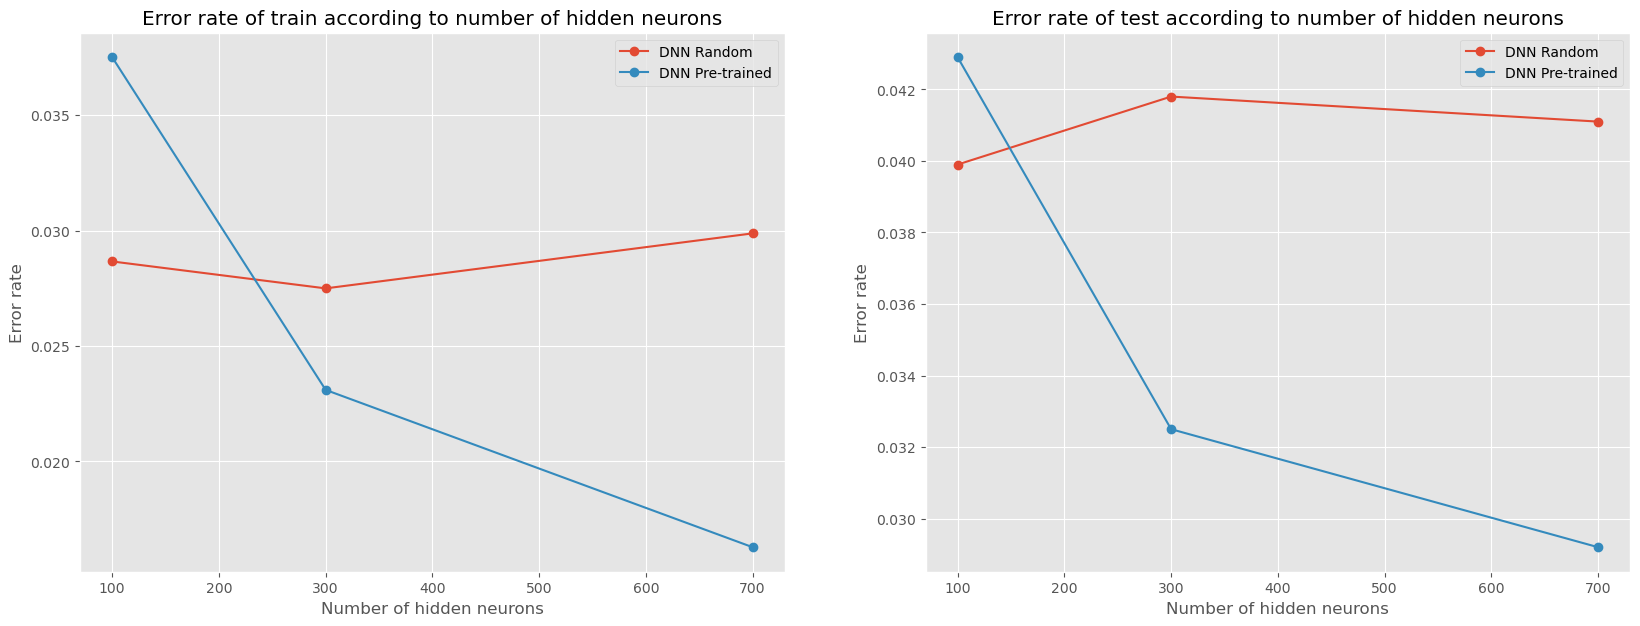

In [37]:
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(1, 2, 2)
plt.plot(nhs, error_test_1, label='DNN Random', marker='o')
plt.plot(nhs, error_test_2, label='DNN Pre-trained', marker='o')
plt.xlabel("Number of hidden neurons")
plt.ylabel("Error rate")
plt.title("Error rate of test according to number of hidden neurons")
plt.legend()

ax = fig.add_subplot(1, 2, 1)
plt.plot(nhs, error_train_1, label='DNN Random', marker='o')
plt.plot(nhs, error_train_2, label='DNN Pre-trained', marker='o')
plt.xlabel("Number of hidden neurons")
plt.ylabel("Error rate")
plt.title("Error rate of train according to number of hidden neurons")
plt.legend()

plt.savefig("Fig2.pdf", format="pdf", bbox_inches="tight")

In [38]:
num_layers = 2
nh = 200
n_samples_list = [3000, 7000, 10000, 30000, 60000]
error_train_1 = []
error_train_2 = []
error_test_1 = []
error_test_2 = []

for n_samples in n_samples_list:
    print(f"Training of network with {n_samples} of train set ")
    dnn_random = init_DNN(height*width, nh, num_layers)
    dnn_pre_trained = init_DNN(height*width, nh, num_layers)

    dnn_random = principal_DNN_MNIST(X_train, y_train, n_samples, dnn_random, False, num_epochs_rbm, num_epochs_retro, lr, batch_size)
    dnn_pre_trained = principal_DNN_MNIST(X_train, y_train, n_samples, dnn_pre_trained, True, num_epochs_rbm, num_epochs_retro, lr, batch_size)
    

    ###### Misclassification rates #######
    print('Calculating errors on the train and test set')
    #Train 
    error_train_1.append(test_DNN(dnn_random, X_train, y_train))
    error_train_2.append(test_DNN(dnn_pre_trained, X_train, y_train))
    #Test
    error_test_1.append(test_DNN(dnn_random, X_test, y_test))
    error_test_2.append(test_DNN(dnn_pre_trained, X_test, y_test))

Training of network with 3000 of train set 
Epoch 0/50 the loss is = 0.16703089594814527
Epoch 1/50 the loss is = 0.15509322485628757
Epoch 2/50 the loss is = 0.14013648042455315
Epoch 3/50 the loss is = 0.12246804825161701
Epoch 4/50 the loss is = 0.10395601151213403
Epoch 5/50 the loss is = 0.0888899313878022
Epoch 6/50 the loss is = 0.07710724890010208
Epoch 7/50 the loss is = 0.06767300339634194
Epoch 8/50 the loss is = 0.061045315176167646
Epoch 9/50 the loss is = 0.05541019537170407
Epoch 10/50 the loss is = 0.051139929043322326
Epoch 11/50 the loss is = 0.047844226421011236
Epoch 12/50 the loss is = 0.04460898875425727
Epoch 13/50 the loss is = 0.04217674191107284
Epoch 14/50 the loss is = 0.03986557398287873
Epoch 15/50 the loss is = 0.03793736513399497
Epoch 16/50 the loss is = 0.036373947750720954
Epoch 17/50 the loss is = 0.034952595057130297
Epoch 18/50 the loss is = 0.03373397150928691
Epoch 19/50 the loss is = 0.03226521238853853
Epoch 20/50 the loss is = 0.03142740636237

#### Figure 3 : Error rate of train and test sets according to number of training samples

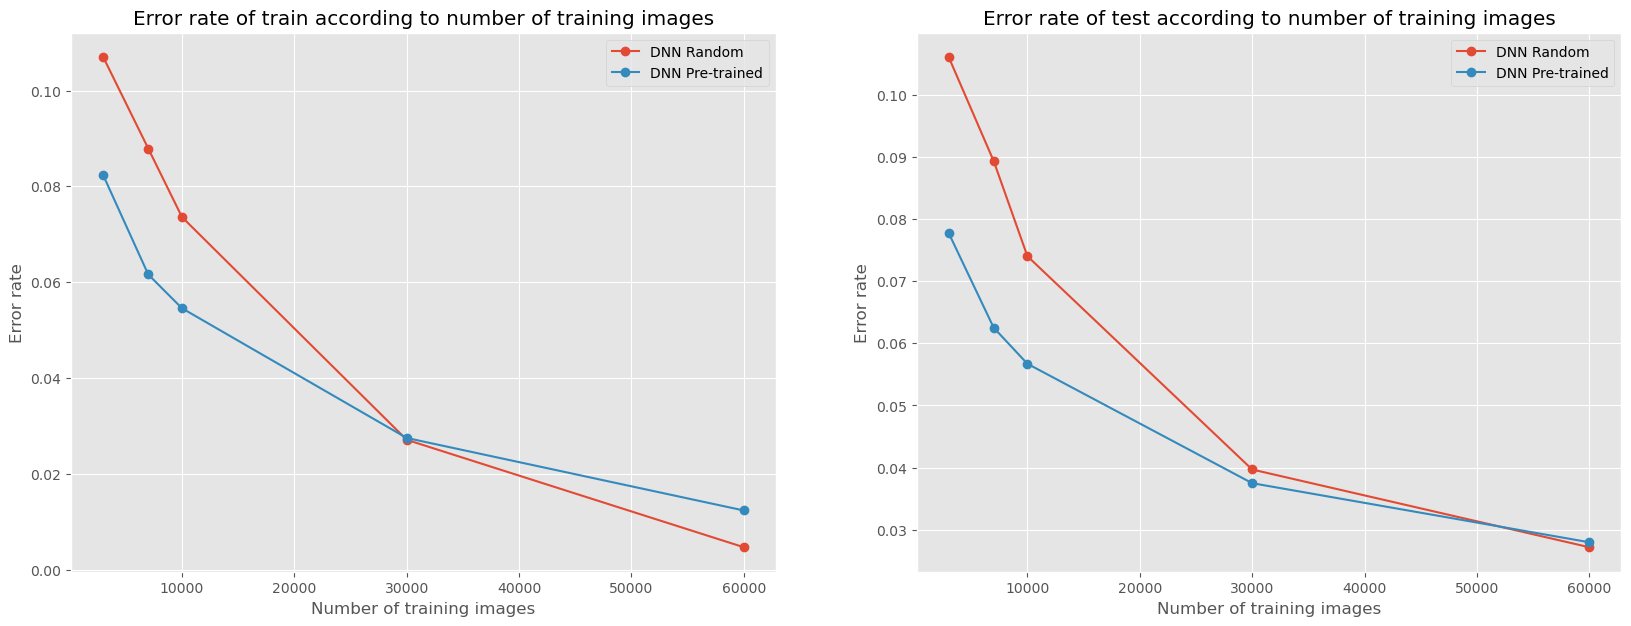

In [40]:
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(1, 2, 2)
plt.plot(n_samples_list, error_test_1, label='DNN Random', marker='o')
plt.plot(n_samples_list, error_test_2, label='DNN Pre-trained', marker='o')
plt.xlabel("Number of training images")
plt.ylabel("Error rate")
plt.title("Error rate of test according to number of training images")
plt.legend()

ax = fig.add_subplot(1, 2, 1)
plt.plot(n_samples_list, error_train_1, label='DNN Random', marker='o')
plt.plot(n_samples_list, error_train_2, label='DNN Pre-trained', marker='o')
plt.xlabel("Number of training images")
plt.ylabel("Error rate")
plt.title("Error rate of train according to number of training images")
plt.legend()

plt.savefig("Fig3.pdf", format="pdf", bbox_inches="tight")

#### $\bullet$ Bonus : Variational Autoencoder


In [58]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from tqdm.notebook import trange, tqdm
import VAEs

In [60]:
#Training Parameters 
batch_size = 64
lr = 1e-2
device = 'cpu'
num_epochs = 50

name_model = 'VAE' # VAE or ConvVAE


if name_model == "VAE":
    x_dim = height*width
    h_dim1 = 512
    h_dim2 = 256
    z_dim = 10
    model = VAEs.VAE(x_dim=x_dim, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim).to(device)

else:
    kernel_size = 4
    in_channels = 1
    out_channels = 8
    latent_size = 16
    model = VAEs.ConvVAE(in_channels, out_channels, kernel_size, latent_size)

In [61]:
#Create the dataloader 
dataset_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(dataset_train, batch_size=batch_size)

dataset_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(dataset_test, batch_size=batch_size)

In [62]:
optimizer = optim.Adam(model.parameters())

In [63]:
#Optimisation Loop
for epoch in trange(num_epochs):
    start_time = time.monotonic()
    print(epoch)
    train_loss = VAEs.train(model, train_loader, optimizer, device)
    valid_loss = VAEs.evaluate(model, test_loader, device)
      
    end_time = time.monotonic()

    epoch_mins, epoch_secs = VAEs.epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss/len(train_loader):.4f} ')
    print(f'\t Val. Loss: {valid_loss/len(test_loader):.4f} ')
          

  0%|          | 0/50 [00:00<?, ?it/s]

0


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 43.9744 
	 Val. Loss: 264.3653 
1


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 43.7404 
	 Val. Loss: 263.8691 
2


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 43.6959 
	 Val. Loss: 263.7201 
3


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 43.6715 
	 Val. Loss: 263.5309 
4


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 43.6439 
	 Val. Loss: 263.3276 
5


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 43.6073 
	 Val. Loss: 263.1260 
6


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 43.5846 
	 Val. Loss: 263.0096 
7


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 43.5667 
	 Val. Loss: 263.0030 
8


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 14s
	Train Loss: 43.5521 
	 Val. Loss: 262.8133 
9


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 14s
	Train Loss: 43.5390 
	 Val. Loss: 262.7868 
10


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 14s
	Train Loss: 43.5271 
	 Val. Loss: 262.7057 
11


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 14s
	Train Loss: 43.5198 
	 Val. Loss: 262.7098 
12


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 14s
	Train Loss: 43.5100 
	 Val. Loss: 262.6932 
13


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 14s
	Train Loss: 43.5004 
	 Val. Loss: 262.5626 
14


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 13s
	Train Loss: 43.4914 
	 Val. Loss: 262.4995 
15


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 13s
	Train Loss: 43.4848 
	 Val. Loss: 262.6392 
16


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 13s
	Train Loss: 43.4773 
	 Val. Loss: 262.4772 
17


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 14s
	Train Loss: 43.4707 
	 Val. Loss: 262.4342 
18


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 14s
	Train Loss: 43.4666 
	 Val. Loss: 262.5000 
19


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 14s
	Train Loss: 43.4619 
	 Val. Loss: 262.4301 
20


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 14s
	Train Loss: 43.4588 
	 Val. Loss: 262.4159 
21


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 14s
	Train Loss: 43.4539 
	 Val. Loss: 262.3327 
22


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 14s
	Train Loss: 43.4512 
	 Val. Loss: 262.3163 
23


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 14s
	Train Loss: 43.4480 
	 Val. Loss: 262.2773 
24


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 14s
	Train Loss: 43.4444 
	 Val. Loss: 262.3327 
25


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 14s
	Train Loss: 43.4425 
	 Val. Loss: 262.2762 
26


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 13s
	Train Loss: 43.4411 
	 Val. Loss: 262.2666 
27


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 14s
	Train Loss: 43.4389 
	 Val. Loss: 262.2483 
28


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 13s
	Train Loss: 43.4370 
	 Val. Loss: 262.2694 
29


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 14s
	Train Loss: 43.4365 
	 Val. Loss: 262.3051 
30


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 14s
	Train Loss: 43.4354 
	 Val. Loss: 262.3067 
31


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 14s
	Train Loss: 43.4314 
	 Val. Loss: 262.2400 
32


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 14s
	Train Loss: 43.4250 
	 Val. Loss: 262.1869 
33


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 13s
	Train Loss: 43.4258 
	 Val. Loss: 262.1604 
34


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 14s
	Train Loss: 43.4177 
	 Val. Loss: 262.1735 
35


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 13s
	Train Loss: 43.4151 
	 Val. Loss: 262.1537 
36


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 14s
	Train Loss: 43.4142 
	 Val. Loss: 262.1782 
37


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 15s
	Train Loss: 43.4127 
	 Val. Loss: 262.0825 
38


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 16s
	Train Loss: 43.4122 
	 Val. Loss: 262.1624 
39


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 13s
	Train Loss: 43.4099 
	 Val. Loss: 262.1282 
40


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 14s
	Train Loss: 43.4007 
	 Val. Loss: 262.0461 
41


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 13s
	Train Loss: 43.3950 
	 Val. Loss: 262.0410 
42


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 13s
	Train Loss: 43.3897 
	 Val. Loss: 262.0232 
43


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 13s
	Train Loss: 43.3802 
	 Val. Loss: 261.9367 
44


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 13s
	Train Loss: 43.3718 
	 Val. Loss: 261.8801 
45


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 13s
	Train Loss: 43.3654 
	 Val. Loss: 261.8622 
46


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 13s
	Train Loss: 43.3574 
	 Val. Loss: 261.8124 
47


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 13s
	Train Loss: 43.3521 
	 Val. Loss: 261.7691 
48


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0m 14s
	Train Loss: 43.3467 
	 Val. Loss: 261.7889 
49


Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 13s
	Train Loss: 43.3451 
	 Val. Loss: 261.7762 


In [65]:
z = torch.randn([5,10])
sample = model.decoder(z).detach().numpy()

In [49]:
height, width = 28, 28
batch_size = 64

##### Generated images by RBM

Epoch : 0/25, Error = 0.026
Epoch : 1/25, Error = 0.022
Epoch : 2/25, Error = 0.020
Epoch : 3/25, Error = 0.018
Epoch : 4/25, Error = 0.017
Epoch : 5/25, Error = 0.016
Epoch : 6/25, Error = 0.016
Epoch : 7/25, Error = 0.015
Epoch : 8/25, Error = 0.015
Epoch : 9/25, Error = 0.015
Epoch : 10/25, Error = 0.014
Epoch : 11/25, Error = 0.014
Epoch : 12/25, Error = 0.014
Epoch : 13/25, Error = 0.014
Epoch : 14/25, Error = 0.014
Epoch : 15/25, Error = 0.013
Epoch : 16/25, Error = 0.013
Epoch : 17/25, Error = 0.013
Epoch : 18/25, Error = 0.013
Epoch : 19/25, Error = 0.013
Epoch : 20/25, Error = 0.013
Epoch : 21/25, Error = 0.013
Epoch : 22/25, Error = 0.013
Epoch : 23/25, Error = 0.012
Epoch : 24/25, Error = 0.012


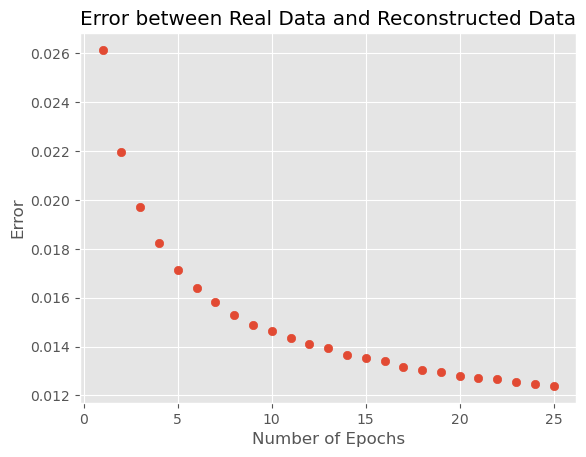

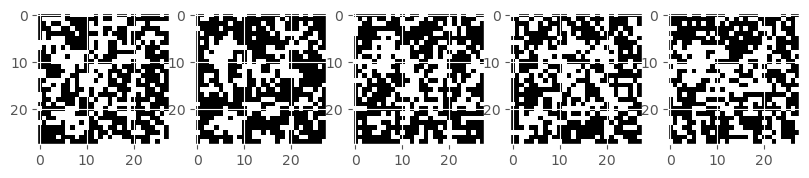

In [53]:
principal_RBM_alpha(X_train, height, width, nh, num_gen=5, num_epoch=25, lr=lr,
                    batch_size=batch_size, num_iter_gibs=10, verbose=True, plot=True)
plt.savefig("Fig4.pdf", format="pdf", bbox_inches="tight")

##### Generated images by DBN

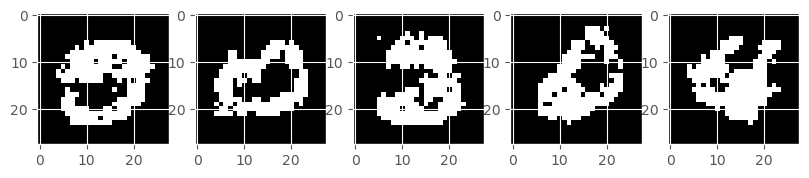

<Figure size 640x480 with 0 Axes>

In [54]:
principal_DBN_alpha(X_train, height, width, nh, num_layers, num_gen=5, num_epoch=25, lr=lr,
                    batch_size=batch_size, num_iter_gibs=10, verbose=False, plot=False)
plt.savefig("Fig5.pdf", format="pdf", bbox_inches="tight")

##### Generated images by VAE

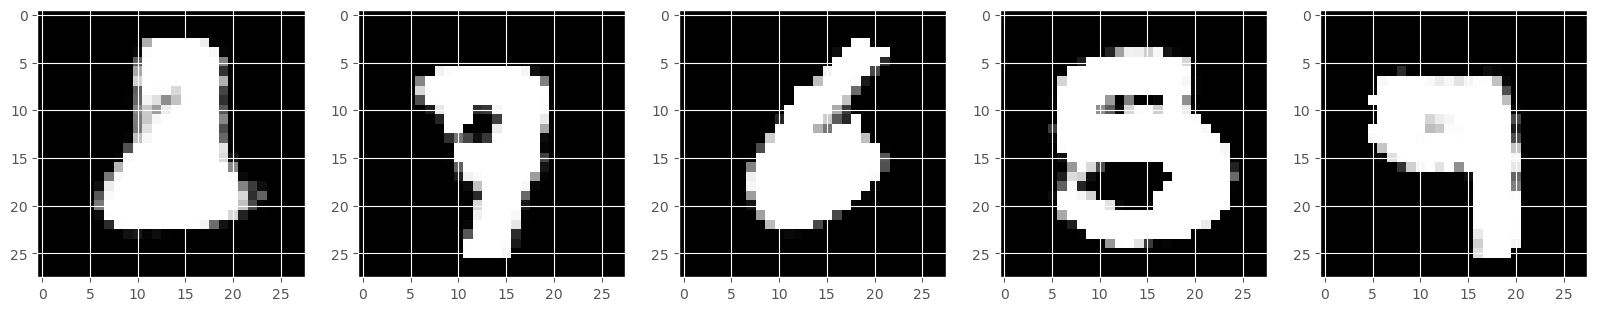

In [69]:
fig = plt.figure(figsize=(20,5))

for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    plt.imshow(sample[i].reshape(28,28), cmap = 'gray')
plt.savefig("Fig6.pdf", format="pdf", bbox_inches="tight")